### Marine Acoustics Workbook

In [1]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pywt

# Figures appear in notebook inline
%matplotlib inline


### Read .wav audio

In [2]:
# File path to .wav file
audio_file_path = "../data/humpback.wav"
filename = audio_file_path.split('/')[-1]

# Read entire mono .wav file using default sampling rate
y, sr = librosa.load(audio_file_path, sr=None, mono=True, offset=0.0, duration=None)
print(f'Loaded file: {filename}\n--------------------------------\n\
Duration: {y.size/sr} seconds\n--------------------------------\n\
Sample rate: {sr} Hz\n--------------------------------\n')



Loaded file: humpback.wav
--------------------------------
Duration: 255.65 seconds
--------------------------------
Sample rate: 4000 Hz
--------------------------------



### Define constants (frame_length, hop_length etc.)

In [3]:
# CONSTANTS
frame_length = 100    # window size in samples
hop_length = frame_length//2    # stride length between windows in samples
n_mels = 64    # no. of mel-bands used to partition linear frequencies
n_mfcc = 12    # no. of mfccs to calculate
wavelet = 'morl'    # wavelet type: morlet
delta_width = 5    # no. of frames over which the delta is calculated

print(f'Frame duration: {1000*frame_length/sr} ms\nOverlap: {100*hop_length/frame_length}%')


Frame duration: 25.0 ms
Overlap: 50.0%


### Functions

In [4]:
def slice_data(data, frame_length, hop_length):
    """Slice 1D array into frames with a given overlap"""
    frame_view = librosa.util.frame(data, frame_length=frame_length, hop_length=hop_length, axis=0)
    
    return frame_view


def apply_cwt(y, sr, scales, wavelet):
    """Apply cwt to a 1D array"""
    
    # Compute continuous wavelet transform
    wavelet_coeffs, wavelet_freqs = pywt.cwt(y, scales, wavelet, sampling_period=1/sr)

    return wavelet_coeffs, wavelet_freqs
    

def scale2frequency(wavelet, scales, sr):
    """Convert from cwt scale to to pseudo-frequency"""

    # pywt function returns normalised frequency so need to multiply by sr
    freqs = pywt.scale2frequency(wavelet, scales) * sr

    return freqs


def frequency2scale(wavelet, desired_freqs, sr):
    """Convert from desired frequencies to a cwt scale"""

    # pywt function input is normalised frequency so need to normalise by sr
    normalised_freqs = desired_freqs / sr
    
    freqs = pywt.scale2frequency(wavelet, normalised_freqs)

    return freqs


def plot_waveform(y, sr, axis='s', offset=0.0, title='Audio Waveform', xlabel='Time (s)', ylabel='Amplitude'):
    """Plot the signal waveform in the time domain"""

    # Plot
    plt.figure()
    librosa.display.waveshow(y, sr=sr, max_points=sr//2, axis=axis, offset=offset)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def plot_dft(y, sr, title='DFT Magnitude', xlabel='Frequency (Hz)', ylabel='Magnitude'):
    """Plot DFT magnitude for a real 1D array"""

    # Calculate DFT
    y_dft = np.fft.rfft(y)

    # Calculate DFT frequency bins
    dft_freqs = np.fft.rfftfreq(y.size, d=1/sr)

    # Plot
    plt.figure()
    plt.plot(dft_freqs, np.abs(y_dft))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)



def plot_spectrogram(y, sr, n_fft=frame_length, hop_length=hop_length, title='Linear-frequency Power Spectrogram', xlabel='Time (s)', ylabel='Frequency (Hz)'):
    """Plot the linear-frequency power spectrogram"""

    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, window='hann')  # STFT of y
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)    # STFT in dB
    
    # Plot
    plt.figure()
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='s', y_axis='linear')
    plt.colorbar(format="%+2.f dB")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def plot_mel_spectrogram(y, sr, n_fft=frame_length, hop_length=hop_length, n_mels=n_mels, title='Mel-frequency Power Spectrogram', xlabel='Time (s)', ylabel='Frequency (Hz)'):
    """Plot the mel-frequency power spectrogram"""

    D = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=frame_length, hop_length=hop_length, n_mels=n_mels)  # mel-power spectrogram of y
    S_db = librosa.power_to_db(D, ref=np.max)    # mel-power spectrogram in dB
    
    # Plot
    plt.figure()
    librosa.display.specshow(S_db, sr=sr, hop_length=hop_length, x_axis='s', y_axis='linear')
    plt.colorbar(format="%+2.f dB")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)


def plot_cwt(y, sr, scales, wavelet):
    """Plot the wavelet scalogram"""

    # Compute continuous wavelet transform
    wavelet_coeffs, wavelet_freqs = apply_cwt(y, sr, scales, wavelet)
    
    # Compute time array
    time = np.arange(0, y.size)/sr

    # Plot the wavelet scalogram.
    plt.figure()
    plt.pcolormesh(time, wavelet_freqs, np.abs(wavelet_coeffs), cmap='magma')
    plt.xlabel("Time (s)")
    plt.ylabel("Pseudo-frequency (Hz)")
    plt.title("Wavelet Scalogram")


### Slice signal into frames

In [5]:
# Create view of sliced signal
y_frames = slice_data(y, frame_length, hop_length)
print(f'Sliced signal into {y_frames.shape[0]} frames with {100*hop_length/frame_length}% overlap and duration {1000*frame_length/sr} ms.')


Sliced signal into 20451 frames with 50.0% overlap and duration 25.0 ms.


### Plot the audio waveform

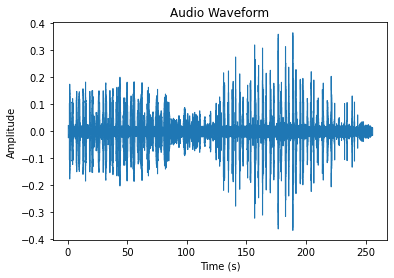

In [6]:
plot_waveform(y, sr)


### Plot the DFT for one frame

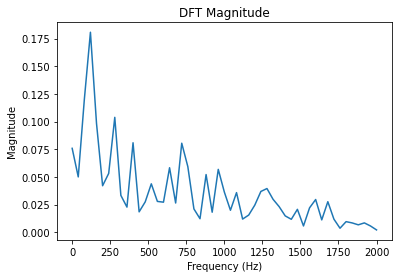

In [7]:
plot_dft(y_frames[50], sr)


### Plot a linear-frequency power spectrogram

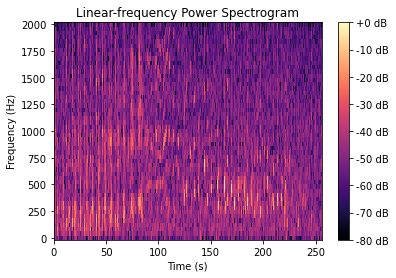

In [8]:
plot_spectrogram(y, sr)


### Plot a mel-frequency power spectrogram

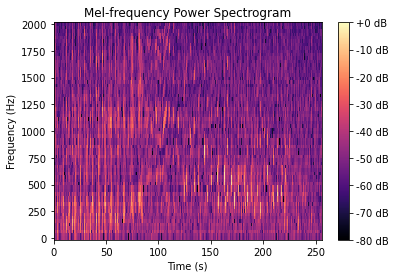

In [9]:
plot_mel_spectrogram(y, sr)


### Plot wavelet scalogram

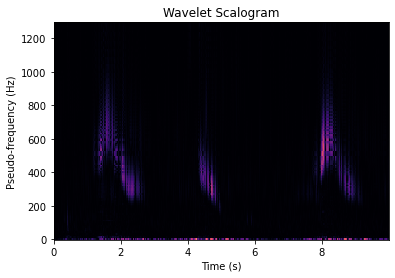

In [10]:
# Select a slice of the audio
t_start = 155
t_end = 165

# Choose wavelet pseudo frequencies
desired_freqs = np.arange(1, 1300, 10)
scales = frequency2scale(wavelet, desired_freqs, sr)

# Plot
plot_cwt(y[sr*t_start:sr*t_end], sr, scales, wavelet)


### Calculate MFCCs, Deltas, and Delta-Deltas

In [11]:
# Calculate MFCCs
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=frame_length, hop_length=hop_length, n_mels=n_mels)
print(f'First {n_mfcc} MFCCs:\n------------------------------------------------------------------\n{mfccs[:,0]}')

# Calculate the delta of the mfccs
mfcc_deltas = librosa.feature.delta(mfccs, width=delta_width, order=1, axis=-1)

# Calculate the delta-deltas of the mfccs
mfcc_delta_deltas = librosa.feature.delta(mfccs, width=delta_width, order=2, axis=-1)



First 12 MFCCs:
------------------------------------------------------------------
[-409.7646       8.581801    15.900955    23.931812     1.0240664
    8.487936    -9.2066555   -5.6914115    7.048259    -0.8699417
    2.377391   -11.291279 ]


### Spectrogram of chirp

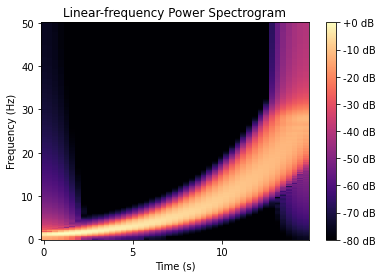

In [12]:
fs = 100
chirp = librosa.chirp(fmin=1, fmax=30, sr=fs, length=None, duration=15)

plot_spectrogram(chirp, fs, n_fft=512, hop_length=32)


### Wavelet scalogram of chirp

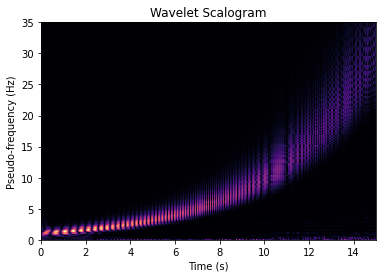

In [13]:
fs = 100
chirp = librosa.chirp(fmin=1, fmax=30, sr=fs, length=None, duration=15)
desired_freqs = np.arange(0.1,35,0.2)
scales = frequency2scale(wavelet, desired_freqs, fs)
#scales = np.arange(800,50, -10)

plot_cwt(chirp, fs, scales, wavelet)
